### Importing necessary libraries (torch, matplotlib)

In [153]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as opt
import torch.nn as nn
import os
import cv2
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

### Path to training and testing datasets

In [154]:
PATH = "C:/Users/Ato/Documents/Programming/Python/catdog/src/datasets"
dataset_path = PATH + "/train"

## Preprocessing and Observations

#### Entries and number of samples of each class

In [155]:
print(len(os.listdir(dataset_path)))


25000


- Taking a look at the filenames, it is possible extracting the name and label with ease with:

In [156]:
filenames = os.listdir(dataset_path)
labels = [filename.split('.')[0] for filename in filenames]

In [157]:
raw_data = {'filename': filenames, 'label': labels}
df = pd.DataFrame(raw_data)


In [158]:
df.head()

,filename,label
0,cat.0.jpg,cat
1,cat.1.jpg,cat
2,cat.10.jpg,cat
3,cat.100.jpg,cat
4,cat.1000.jpg,cat


In [159]:
df.describe()

,filename,label
count,25000,25000
unique,25000,2
top,cat.0.jpg,cat
freq,1,12500


#### Checking balance

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<function matplotlib.pyplot.show(close=None, block=None)>

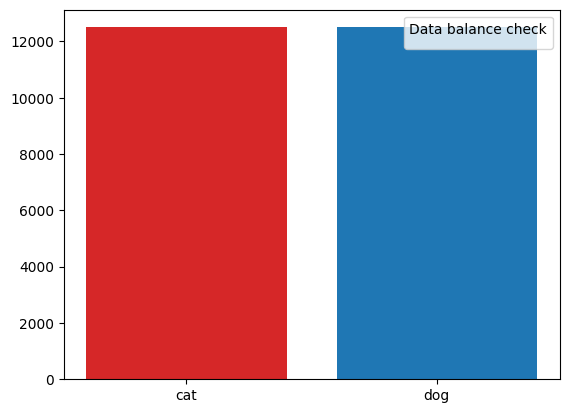

In [160]:
fig, ax = plt.subplots()
bar_labels = df['label'].value_counts().index
counts = df['label'].value_counts().values
bar_colors = ['tab:red', 'tab:blue']

ax.bar(bar_labels, counts, color=bar_colors)
ax.legend(title="Data balance check")

plt.show

The data is balanced! Let's continue.

## Analizing dimensions, shapes, sizes,...

- Take a smaller sample but big enough to contain useful information. sample = 5000

In [161]:
import cv2
from PIL import Image

In [162]:
sample_size = 5000
sample_images = df['filename'].sample(sample_size).to_list()


In [164]:
width = []
height = []
channels = [] # channels

for filename in sample_images:
  image = cv2.imread(os.path.join(dataset_path, filename), 1)
  width.append(image.shape[1])
  height.append(image.shape[0])
  channels.append(image.shape[2])




In [165]:
sample_dimensions = pd.DataFrame({
  'width':width,
  'height':height,  
  'channels':channels
})

sample_dimensions.head()

,width,height,channels
0,412,500,3
1,499,375,3
2,499,340,3
3,324,242,3
4,319,215,3


In [166]:
sample_dimensions['aspect ratio'] = sample_dimensions['width']/sample_dimensions['height']

In [167]:
sample_dimensions.head()

,width,height,channels,aspect ratio
0,412,500,3,0.824000
1,499,375,3,1.330667
2,499,340,3,1.467647
3,324,242,3,1.338843
4,319,215,3,1.483721


In [168]:
sample_dimensions.describe()

,width,height,channels,aspect ratio
count,5000.000000,5000.00000,5000.0,5000.000000
mean,407.502000,363.84700,3.0,1.155639
std,107.323446,96.15383,0.0,0.286686
min,50.000000,38.00000,3.0,0.375940
25%,335.000000,312.00000,3.0,0.924922
50%,450.000000,374.00000,3.0,1.275994
75%,499.000000,427.00000,3.0,1.336898
max,500.000000,500.00000,3.0,2.994012


We calculate the percentile 95th, so we know what value the majority of the features have.

It seems that most of the values are below 500 in width and height and hte aspect ratio is about 1.5, which means that the width is usually 1.5 times bigger than the height.

In [169]:
np.quantile(width, 0.95), np.quantile(height, 0.95), np.quantile(sample_dimensions['aspect ratio'], 0.95)

(500.0, 500.0, 1.5063048088496591)

- Trying with different methods to obtain the quantile. All produce the same value.

In [170]:
np.quantile(width, 0.95, method='hazen'), np.quantile(width, 0.95, method='closest_observation'), np.quantile(width, 0.95, method='higher'), np.quantile(width, 0.95, method='averaged_inverted_cdf'), np.quantile(width, 0.95, method='linear'), np.quantile(width, 0.95, method='median_unbiased')


(500.0, 500, 500, 500.0, 500.0, 500.0)

In [171]:
samplesandnames = sample_dimensions
#print(sample_images[:10])
samplesandnames['filename'] = sample_images

## Removing Outliers

The maximum goal is to preserve quality. From the quantiles, it has been deducted that most of the width and height values fall below 500 while the aspect ratio (AR) is 1.5 in the majority of cases. More data is lost when oversampling the images than when undersampling them, so only the smallest widths and heghts will be removed. Since most of the aspect ratio values fall below 1.5, all AR values between 0.7 and 2 will be removed as well.

- Width > 150
- Height > 100
- 0.7 > Aspect Ratio > 2

These values can be tuned to obtain different results.
**The smaller the range, the lesser data.**


In [172]:
processed_samples = samplesandnames[
  (samplesandnames['width'] >= 150) &
  (samplesandnames['height'] >= 100) &
  (samplesandnames['aspect ratio'] >= 0.7) &
  (samplesandnames['aspect ratio'] <= 2)
]

processed_samples = processed_samples.reset_index(drop=True)


In [173]:
processed_samples.head()

,width,height,channels,aspect ratio,filename
0,412,500,3,0.824000,cat.3027.jpg
1,499,375,3,1.330667,cat.10302.jpg
2,499,340,3,1.467647,dog.10900.jpg
3,324,242,3,1.338843,dog.11716.jpg
4,319,215,3,1.483721,cat.967.jpg


Now that the **outliers** have been deleted, the amount of data reduced needs to be checked out. Looking at the outcome, most of the images are not considered outliers, although almost 10% of the sample data has been removed.

In [174]:
processed_samples.describe()

,width,height,channels,aspect ratio
count,4580.000000,4580.000000,4580.0,4580.000000
mean,422.016376,365.265721,3.0,1.184853
std,95.570114,87.720510,0.0,0.247496
min,150.000000,104.000000,3.0,0.700000
25%,357.000000,320.000000,3.0,0.987495
50%,479.000000,374.000000,3.0,1.324572
75%,499.000000,413.000000,3.0,1.336898
max,500.000000,500.000000,3.0,1.996000


## Global Preprocessing

- The same sample preprocessing is now applied to all data.

In [175]:
import cv2
from PIL import Image

In [176]:
df.head(), len(df.filename)

(       filename label
 0     cat.0.jpg   cat
 1     cat.1.jpg   cat
 2    cat.10.jpg   cat
 3   cat.100.jpg   cat
 4  cat.1000.jpg   cat,
 25000)

- Before removing outliers, 10% of the data (len(df)*0.1) that will be used for testing the model is substracted from the dataset.

In [177]:
testing = df.sample(n=int(len(df)*0.1)).reset_index(drop=True)

- Adding ALL images shapes to the lists. Later the 

In [178]:
width = []
height = []

for filename in df['filename']:
  image = cv2.imread(os.path.join(dataset_path, filename))  
  width.append(image.shape[1])
  height.append(image.shape[0])

    

### Outliers Note

- Width > 100
- Height > 150
- 0.7 > Aspect Ratio > 2

In [179]:
full_data = pd.DataFrame({'filename': df['filename'], 'width': width, 'height': height, 'label': df['label']})

In [180]:
full_data.describe(), df.describe()

(             width        height
 count  25000.00000  25000.000000
 mean     404.09904    360.478080
 std      109.03793     97.019959
 min       42.00000     32.000000
 25%      323.00000    301.000000
 50%      447.00000    374.000000
 75%      499.00000    421.000000
 max     1050.00000    768.000000,
          filename  label
 count       25000  25000
 unique      25000      2
 top     cat.0.jpg    cat
 freq            1  12500)

In [181]:
full_data['aspect ratio'] = full_data['width'] / full_data['height']

- Creating a mask to identify the filenames in both full_data and validation

In [182]:
mask = full_data['filename'].isin(testing['filename'])
mask.describe()

count     25000
unique        2
top       False
freq      22500
Name: filename, dtype: object

- Removing duplicated values

In [183]:
train_data = full_data[~mask]
train_data.describe()

,width,height,aspect ratio
count,22500.000000,22500.000000,22500.000000
mean,404.154889,360.720222,1.156533
std,108.965233,96.990081,0.290620
min,42.000000,32.000000,0.306613
25%,323.000000,301.000000,0.929455
50%,447.000000,374.000000,1.268116
75%,499.000000,421.000000,1.336898
max,1050.000000,768.000000,3.815789


In [184]:
train_data = train_data[
  (train_data['width'] >= 100) &
  (train_data['height'] >= 150) &
  (train_data['aspect ratio'] >= 0.7) &
  (train_data['aspect ratio'] <= 2)
]

- Checking if the data is still balanced after preprocessing. It is!

Text(0, 0.5, 'Count')

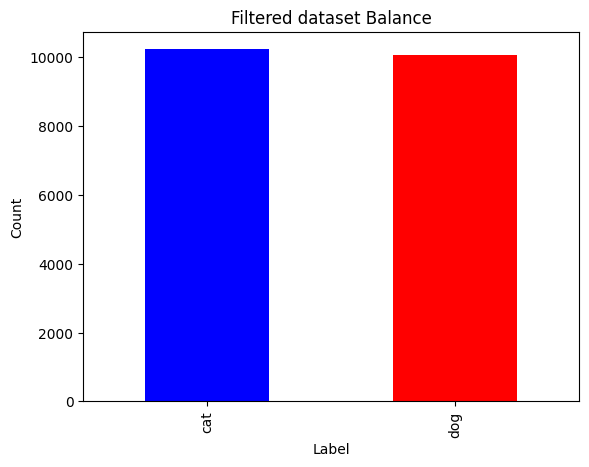

In [185]:
train_data['label'].value_counts().sort_index().plot(kind='bar', color=['blue', 'red'])

plt.title('Filtered dataset Balance')
plt.xlabel('Label')
plt.ylabel('Count')

## Shuffle

Before splitting into training and validation it is necessary to shuffle the data to avoid overfitting due to predetermined orders.


In [186]:
# frac = 1 -> all data
# drop=True --> removes old index and creates a new one for the new sorted dataframe
# If no index is desired:
#   1. full_data.sample(frac=1).reset_index(drop=True, inplace=True) -> with the original dataframe (full_data)
#   2. shuffled_data.to_csv('shuffled_data.csv', index=False) -> with a new variable
shuffled_data = train_data.sample(frac=1).reset_index(drop=True) 
shuffled_data.describe()

,width,height,aspect ratio
count,20306.000000,20306.000000,20306.000000
mean,421.315276,363.581995,1.185331
std,95.962193,86.050366,0.247576
min,109.000000,150.000000,0.700000
25%,352.000000,315.000000,0.989467
50%,479.000000,374.000000,1.323607
75%,499.000000,405.000000,1.336898
max,1050.000000,768.000000,2.000000


## Validation - Training set split

Since the features width, height and aspect ratio were created only for preprocessing purposes it is safe to remove them. Furthermore, it is a good practice to create a checkpoint of the data

In [187]:
# Checkpoint

'''
Internally, in python, copy() method uses a pointer to the original data, which
means that changes to the new object will affect the old. To overcome this, set deep=True.
For non-pandas objects, use copy.deepcopy(<object>)
'''

data = shuffled_data.copy(deep=True)
data.head()

,filename,width,height,label,aspect ratio
0,dog.9417.jpg,500,363,dog,1.377410
1,cat.242.jpg,500,374,cat,1.336898
2,dog.4811.jpg,499,412,dog,1.211165
3,cat.8740.jpg,500,374,cat,1.336898
4,cat.11097.jpg,500,374,cat,1.336898


In [188]:
# Drop unwwanted features

data = data.drop(['width', 'height', 'aspect ratio'], axis=1)
data.head()

,filename,label
0,dog.9417.jpg,dog
1,cat.242.jpg,cat
2,dog.4811.jpg,dog
3,cat.8740.jpg,cat
4,cat.11097.jpg,cat


- Set integers for labels instead of strings using a simple lambda function

In [189]:
testing.head()

,filename,label
0,cat.9164.jpg,cat
1,cat.8804.jpg,cat
2,cat.7257.jpg,cat
3,dog.1903.jpg,dog
4,cat.2065.jpg,cat


In [190]:
data["label"] = data["label"].apply(lambda x: 1 if x == 'dog' else 0)
testing["label"] = testing["label"].apply(lambda x: 1 if x == 'dog' else 0)
data.head(), testing.head()

(        filename  label
 0   dog.9417.jpg      1
 1    cat.242.jpg      0
 2   dog.4811.jpg      1
 3   cat.8740.jpg      0
 4  cat.11097.jpg      0,
        filename  label
 0  cat.9164.jpg      0
 1  cat.8804.jpg      0
 2  cat.7257.jpg      0
 3  dog.1903.jpg      1
 4  cat.2065.jpg      0)

In [191]:
data_length = len(data.index)
data_length

20306

After preprocessing, there are still more than 20000 images. A ratio of 80% (training) 20% (validation) for this amoount of data seems correct

In [192]:
train_len_round = round(len(data.index)*0.8)
train_len_int = int(len(data.index)*0.8)
train_len_float = len(data.index)*0.8

print(f'Rounded {train_len_round}')
print(f'int {train_len_int}')
print(f'float {train_len_float}')

print(f'Error round: {abs(train_len_float-train_len_round)}')
print(f'Error int: {abs(train_len_float-train_len_int)}')

# More precision using round

Rounded 16245
int 16244
float 16244.800000000001
Error round: 0.1999999999989086
Error int: 0.8000000000010914


In [193]:
train_df = data.iloc[:train_len_round,:]
val_df = data.iloc[train_len_round:, :]

train_df.shape, val_df.shape

((16245, 2), (4061, 2))

In [194]:
train_df.shape[0]/data_length, val_df.shape[0]/data_length

(0.8000098493056239, 0.19999015069437603)

In [195]:
abs_err_train = abs(0.8-train_df.shape[0]/data_length)
abs_err_val = abs(0.2-val_df.shape[0]/data_length)

errors = [abs_err_train, abs_err_val]

print(f'Absolut errors: {errors}')

Absolut errors: [9.849305623865767e-06, 9.84930562397679e-06]


Splitting completed with a small error (Ea ~ 9.849e-6)

## Model with Pytorch

The dataset will be fed to a convolutional neural network model. This model is defined below and its main file can be found in `/modules/cnn.py`. For the moment, it has 2 convolutional layers, 2 pooling layers and 3 fully connected layers. The input depends on the size of the kernels and the image resizing.
To calculate the input-size in the neural networks, refer to https://github.com/BakiRhina/Cats-and-Dogs#important-note-on-fc1-shape.


In [196]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(3,6,5) # (N_in_channels, N_out_channels, kernel_size)
    self.conv2 = nn.Conv2d(6,16,5)
    self.pool = nn.MaxPool2d(2,2)
    self.fc1 = nn.Linear(16*93*61, 256)
    self.fc2 = nn.Linear(256, 120)
    self.fc3 = nn.Linear(120, 2)

  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = torch.flatten(x, 1) 
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x
  


Neural networks, specially if fed with big datasets containing images, consume lots of resources. That is why using cudas gpu is a good option if available, to reduce time consumption.

In [197]:
# Select GPU if available (cuda toolkit <= 11.8 for pytorch)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f"Training on device: {device}")

# Enables benchmark mode in cudnn to find the best algorithm to use for your hardware.
#more info --> https://pytorch.org/docs/stable/backends.html#torch.backends.mps.is_built
torch.backends.cudnn.benchmark = True

Training on device: cuda:0


As before, looking at the 95% percentile, the aspect ratio is around 1.5. Therefore, some combinations to try out, without loosing much resolution and information would be: (384,256,3);(256,256,3);(128,128,3);...

In [198]:
#Uncomment to try different sizes

input_shape = (384,256)
#input_shape = (256,256)
#input_shape = (128,128)

df_transform = transforms.Compose([
  transforms.Resize(input_shape),
  transforms.ToTensor()
])

In [199]:
train_df.describe()

,label
count,16245.000000
mean,0.496584
std,0.500004
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


- Why the custom dataset? It is possible to use the class Dataset to create Dataset-like objects and then pass it to the DataLoader. This class is optimized to be less memory consuming (processes data in separate cores in real time and feed it immediately to the model)

In [200]:
from torch.utils.data import Dataset

class CustomDataset(Dataset):
  def __init__(self, dataframe, root_dir , transform=None):
    self.dataframe = dataframe
    self.root_dir = root_dir
    self.transform = transform
  
  #DataLoader will automatically use these methods (__len__() and __getitem__())
  #To calculate the amount of iterations with the selected batch
  def __len__(self):
    return len(self.dataframe)

  #To select the samples of data form the dataframe
  def __getitem__(self, idx):
    img_filepath = os.path.join(self.root_dir, self.dataframe.iloc[idx, 0])
    image = Image.open(img_filepath).convert("RGB")
    label = self.dataframe.iloc[idx, 1]

    if self.transform:
      image = self.transform(image)

    return image, label
  

- Instance of training and validating sets

In [209]:
train_set = CustomDataset(train_df, dataset_path, transform=df_transform)
val_set = CustomDataset(val_df, dataset_path, transform=df_transform)
testing_set = CustomDataset(testing, dataset_path, transform=df_transform)

- Torch loader with batch size of 16/32, and shuffled again.

In [203]:
batch_size = 32
lr = 0.0001
momentum = 0.9
epochs = 2

In [239]:
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True)
testing_loader = DataLoader(testing_set, batch_size=1, shuffle=True)

### Training loop

In [205]:
cnn = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = opt.SGD(cnn.parameters(), lr, momentum)
loss_values = []

for epoch in range(0, epochs):
  print(f'Epoch {epoch}')
  running_loss = 0.0
  for i, data in enumerate(train_loader, 0):
    imgs, label = data
    imgs, label = imgs.to(device), label.to(device)

    # zero the parameter gradients
    optimizer.zero_grad()

    # Forward pass + Backward pass + Gradient optimization
    output = cnn(imgs)
    loss = criterion(output, label)
    loss.backward()
    optimizer.step()

    # print statistics
    if i % 50 == 49:
      running_loss += loss.item()
      print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 50:.5f}')
      loss_values.append(running_loss)
      running_loss = 0.0

print("Training finished!")

Epoch 0
[1,    50] loss: 0.01391
[1,   100] loss: 0.01378
[1,   150] loss: 0.01396
[1,   200] loss: 0.01382
[1,   250] loss: 0.01388
[1,   300] loss: 0.01387
[1,   350] loss: 0.01383
[1,   400] loss: 0.01384
[1,   450] loss: 0.01387
[1,   500] loss: 0.01385
Epoch 1
[2,    50] loss: 0.01384
[2,   100] loss: 0.01384
[2,   150] loss: 0.01384
[2,   200] loss: 0.01379
[2,   250] loss: 0.01383
[2,   300] loss: 0.01376
[2,   350] loss: 0.01379
[2,   400] loss: 0.01385
[2,   450] loss: 0.01385
[2,   500] loss: 0.01386
Training finished!


In [206]:
model_filename = 'model11.pth'
model_path = f'models/{model_filename}'

torch.save(cnn.state_dict(), model_path)

#### FC1 input calculation

When changing the structure of the CNN or the batch size, run this to know the dimensions of the input layer.

In [ ]:
images, labels = next(iter(train_loader))

In [ ]:
conv1 = nn.Conv2d(3,6,5)
pool = nn.MaxPool2d(2,2)
conv2 = nn.Conv2d(6,16,5)

print(images.shape)

x = conv1(images)
print(x.shape)
x = pool(x)
print(x.shape)
x = conv2(x)
print(x.shape)
x = pool(x)
print(x.shape)
x = torch.flatten(x, 1)
print(x.shape)

torch.Size([32, 3, 384, 256])
torch.Size([32, 6, 380, 252])
torch.Size([32, 6, 190, 126])
torch.Size([32, 16, 186, 122])
torch.Size([32, 16, 93, 61])
torch.Size([32, 90768])


## Validation



In [207]:
cnn = CNN()
cnn.load_state_dict(torch.load(model_path))
cnn.eval()
cnn.to(device)
cnn.eval

<bound method Module.eval of CNN(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=90768, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=2, bias=True)
)>

In [232]:
with torch.no_grad():
  
  running_loss = 0.0

  for i, data in enumerate(val_loader, 0):
    images, labels = data
    images, labels = images.to(device), labels.to(device)

    output = cnn(images)

    loss = criterion(output, labels)
    
    if i%20 == 19:
      running_loss += loss
      print(f'loss: {running_loss / 50:.5f}')
      

tensor([0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1,
        0, 1, 1, 0, 1, 0, 0, 0], device='cuda:0')
tensor([[-0.0544, -0.0456],
        [-0.0349, -0.0679],
        [-0.0531, -0.0462],
        [-0.0565, -0.0400],
        [-0.0556, -0.0406],
        [-0.0421, -0.0621],
        [-0.0448, -0.0601],
        [-0.0478, -0.0581],
        [-0.0428, -0.0600],
        [-0.0603, -0.0369],
        [-0.0413, -0.0582],
        [-0.0388, -0.0671],
        [-0.0497, -0.0502],
        [-0.0423, -0.0585],
        [-0.0438, -0.0632],
        [-0.0537, -0.0519],
        [-0.0354, -0.0674],
        [-0.0480, -0.0533],
        [-0.0447, -0.0622],
        [-0.0442, -0.0589],
        [-0.0685, -0.0268],
        [-0.0333, -0.0723],
        [-0.0364, -0.0646],
        [-0.0407, -0.0618],
        [-0.0548, -0.0479],
        [-0.0615, -0.0400],
        [-0.0336, -0.0699],
        [-0.0379, -0.0672],
        [-0.0486, -0.0537],
        [-0.0461, -0.0551],
        [-0.0554, -0.0468],
  

KeyboardInterrupt: 

## TESTING

In [214]:
cnn = CNN()
cnn.load_state_dict(torch.load(model_path))
cnn.eval()
cnn.to(device)
cnn.eval

<bound method Module.eval of CNN(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=90768, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=2, bias=True)
)>

In [240]:
acc = []

for i, data in enumerate(testing_loader):
  imgs, labels = data
  imgs, labels = imgs.to(device), labels.to(device)

  output = cnn(imgs)
  probabilities = F.softmax(output, dim=1)
  predicted_class = torch.argmax(probabilities, dim=1)
  if predicted_class == labels:
    acc.append(int(1))
  else:
    acc.append(int(0))
  
accuracy = sum(acc)/len(testing_loader)
print(f"TOTAL ACCURACY: {accuracy}")

TOTAL ACCURACY: 0.5564
